In [58]:
#%pylab
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.optimize import minimize
from numba import njit
from scipy.stats import poisson
from os.path import isfile

def inference_experiment(gamma=2.5, background=1e-1, aperture=30, N50=100,res=0.1):
    radii = generate_radii(gamma,background,aperture,N50,1.)
    rbins = np.linspace(0,aperture,int(aperture/res))
    N = np.histogram(radii,rbins)[0]
    mu0_est = 3/(np.pi*radii[2]**2)
    p0 = (np.log10(mu0_est),np.log10(background*mu0_est), 0., gamma)
    for i in range(100):
        sol = minimize(lossfunc, np.array(p0) + 0.1*np.random.rand(),args=(rbins,N),method='Nelder-Mead',bounds=[(-10,10),(-10,10),(-10,10),(0,10)],tol=1e-6)
        if sol.success: 
            #if(i>0): print(i)
            break

    if sol.success:    
        return sol.x[2:]
    else:
        return [np.nan, np.nan]

def generate_radii(gamma=2.5, background=1e-1, Rmax=100, N50=100,a=1):
    np.random.seed()
    r = np.logspace(-2,np.log10(Rmax),1000)
    norm = 2*np.pi/(gamma - 2)
    r50 = (2**(2/(gamma-2))-1)**0.5 
    sigma = norm * (1 + r**2)**(-gamma/2)
    ecdf = cumtrapz(2*np.pi*r*(sigma + background), r,initial=0);
    ecdf /= ecdf.max()
    frac_within_r50 = np.interp(r50,r,ecdf)
    sample_size = round(N50/frac_within_r50)
    samples = np.interp(np.sort(np.random.rand(sample_size)), ecdf, r)
    return np.sort(samples)*a

def lossfunc(x,rbins,bincounts):
    logmu0, logbackground, loga, gam = x
    mu, bg, a = 10**logmu0, 10**logbackground, 10**loga
    cumcounts_avg = 2*a**gam*np.pi*(a**(2-gam) - (a**2 + rbins**2)**(1-gam/2))* mu  / (gam-2) + np.pi*rbins**2*bg
    expected_counts = np.diff(cumcounts_avg)
    prob = poisson.logpmf(bincounts, expected_counts).sum()
    return -prob


In [60]:
from multiprocessing import Pool
Nsamples = 3*10**4

params = {"Fiducial": [2.5,1e-1,10,10**3,0.1],
          r"$10^4$ stars" : [2.5,1e-1,10,10**4,0.1],
          r"$3\times10^3$ stars" : [2.5,1e-1,10,3*10**3,0.1],
          r"$3\times10^2$ stars" : [2.5,1e-1,10,3*10**2,0.1],
          r"$30$ stars" : [2.5,1e-1,10,30,0.1],
          r"$10^2$ stars": [2.5,1e-1,10,10**2,0.1],
          r"Aperture 100": [2.5,1e-1,100,10**3,0.1],
          r"Aperture 30": [2.5,1e-1,30,10**3,0.1],
          r"Aperture 3": [2.5,1e-1,3,10**3,0.1],
          r"$\gamma=2.1": [2.1,1e-1,10,10**3,0.1],
          r"$\gamma=2.3": [2.3,1e-1,10,10**3,0.1],
          r"$\gamma=3": [3.,1e-1,10,10**3,0.1],
          r"$\gamma=4$": [4.,1e-1,10,10**3,0.1],
          r"Resolution 0.01a": [2.5,1e-1,10,10**3,0.01],
          r"Resolution 1a":[2.5,0.1,10,10**3,1.],
          r"Contrast 1": [2.5,1.,10,10**3,0.1],
          r"Contrast 100": [2.5,0.01,10,10**3,0.1]
}


for label, p in params.items():
    #if p[3] > 100: continue
    print(label)
    path = f"r50_samples_{str(hash(label))}.npy"
    if isfile(path):
        if len(np.load(path)) == Nsamples: continue    
    with Pool(15) as pool:
        result = np.array(pool.starmap(inference_experiment, Nsamples*[p]))
    np.save(path, result)

Fiducial
$10^4$ stars
$3\times10^3$ stars
$3\times10^2$ stars
$30$ stars
$10^2$ stars
Aperture 100
Aperture 30
Aperture 3


Fiducial


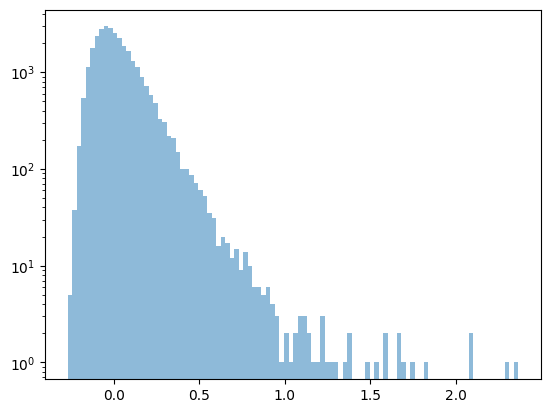

In [52]:
for label, p in params.items():
    print(label)
    path = f"r50_samples_{str(hash(label))}.npy"
    r50_0 = (2**(2/(p[0]-2))-1)**0.5
    
    if isfile(path):
        result = np.load(path)
        r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
        #print(label, np.isnan(r50).sum(),(result[:,1]<2).sum())
        plt.hist(np.log10(r50/r50_0).clip(-2,10),100,alpha=0.5); plt.yscale('log')
    break

In [56]:
np.log10(r50).std()

0.1489935048773844

In [30]:
result = np.array(result)
r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
r50_0 = (2**(2/(default_params[0]-2))-1)**0.5
plt.hist((r50/r50_0),100)

NameError: name 'default_params' is not defined

In [4]:
#np.max(10**result[:,0]*np.sqrt(2**(2/(np.array(result[:,1])-2))-1)/(2**(2/(2.5-2))-1)**0.5)
plt.show()

In [5]:
(r50/r50_0)

array([1.0293141 , 0.91322961, 0.96702703, ..., 1.04533659, 1.00717767,
       0.9054228 ])

In [49]:
%lprun -f lossfunc inference_experiment()

2093.074018083576
2.5 2.952574685026501


Timer unit: 1e-09 s

Total time: 0.0451768 s
File: /tmp/ipykernel_24507/3469436785.py
Function: lossfunc at line 34

Line #      Hits         Time  Per Hit   % Time  Line Contents
    34                                           def lossfunc(x,rbins,bincounts):
    35       272     694987.0   2555.1      1.5      logmu0, logbackground, loga, gam = x
    36       272     421873.0   1551.0      0.9      mu, bg, a = 10**logmu0, 10**logbackground, 10**loga
    37       272   10836445.0  39839.9     24.0      cumcounts_avg = 2*a**gam*np.pi*(a**(2-gam) - (a**2 + rbins**2)**(1-gam/2))* mu  / (gam-2) + np.pi*rbins**2*bg
    38       272    2744743.0  10091.0      6.1      expected_counts = np.diff(cumcounts_avg)
    39       272   30379007.0 111687.5     67.2      prob = poisson.logpmf(bincounts, expected_counts).sum()
    40       272      99762.0    366.8      0.2      return -prob